In [14]:
import quantecon as qe

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from numba import njit, vectorize, float64
from numpy import sin, cos, sqrt
import numpy as np

from quantecon.optimize.root_finding import newton, brentq

import time
import scipy
import scipy.optimize

# Parameters for case D testing
gamma = 5000
beta = (1-1/gamma**2)**(1/2)
lamb = 0.02

## The root-finding function for case D is:

$$ f(\alpha, \xi, \chi, \beta, \lambda) = \alpha + \frac{1}{2}\left(\lambda - \beta\sqrt{\lambda^2 + \chi^2 + 4(1+\chi)\sin^2(\alpha) + 2\lambda\sin(2\alpha)}\right) - \xi. $$
The goal is to find $\alpha_0$ such that $f(\alpha = \alpha_0) = 0$.

Some numerical root finders ( e.g. Newton ) expect $f'(\alpha)$ for accuracy. With chain rule we have:

$$ f'(\alpha) = 1 - \frac{\beta}{4}\left( \lambda^2 + \chi^2 + 4(1+\chi)\sin^2(\alpha) + 2\lambda\sin(2\alpha)\right)^{-1/2} \times (8(1+\chi)\sin(\alpha)\cos(\alpha) + 4\lambda\cos(2\alpha)) $$

With simplification:
$$ f'(\alpha) = 1 - \beta \left( \frac{2(1+\chi)\sin(\alpha)\cos(\alpha) + \lambda\cos(2\alpha)}{ \sqrt{ \lambda^2 + \chi^2 + 4(1+\chi)\sin^2(\alpha) + 2\lambda\sin(2\alpha) }}  \right) $$

In [3]:
# Note that ff can NOT be np-vectorized since it will be called by the jitted "newton" ot "brentq".

@njit
def ff(a, z, x, beta, lamb):
    return a + 1/2 * (lamb - beta* sqrt(lamb**2 + x**2 + 4*(1+x)*sin(a)**2 + 2*lamb*sin(2*a)) - z)

@njit
def ff_prime(a, z, x, beta, lamb):
    return 1 - beta * (2*(1+x)*sin(a)*cos(a) + lamb*cos(2*a)) / sqrt(lamb**2 + x**2 + 4*(1+x)*sin(a)**2 + 2*lamb*sin(2*a))


In [4]:
# Newton needs the first derivate and a good initial guess ( otherwise may not converge )  
print(newton(ff, 0, ff_prime, args=(1e-5, 1e-5, beta, lamb))[0])

@vectorize([float64(float64, float64, float64, float64, float64)], target='parallel')
def newton_vec_ff(a0, z, x, beta, lamb):
    return newton(ff, a0, ff_prime, args=(z, x, beta, lamb))[0]

print( newton_vec_ff(0, 1e-5, 1e-5, beta, lamb) )
print( newton_vec_ff(0, 1.1e-5, 1e-5, beta, lamb))
print( newton_vec_ff(0, 2.1e-5, 1e-5, beta, lamb))

0.02548575935978343
0.02548575935978343


RuntimeError: Failed to converge

## Since Newton is hard to use ( have to guess initial $\alpha$ smartly ), let's try the Brent's method

In [5]:
# Brent's method needs a "guess interval" 
print( brentq(ff, -0.01, 0.1, args=(1e-5, 1e-5, beta, lamb))[0])

@vectorize([float64(float64, float64, float64, float64)], target='parallel')
def brentq_vec_ff(z, x, beta, lamb):
    #return brentq(ff, -0.01, 0.1, args=(z, x, beta, lamb))[0]
    return brentq(ff, -1, 1, args=(z, x, beta, lamb))[0]

print(brentq_vec_ff( 1e-5, 1e-5, beta, lamb))
print(brentq_vec_ff( 1.1e-5, 1e-5, beta, lamb))
print(brentq_vec_ff( 2.1e-5, 1e-5, beta, lamb))

0.025485759359775418
0.025485759359768323
0.02640272292353774
0.03354960543650097


## Timing test

In [6]:
# Define a simple 2D grid 

zvec = np.linspace(-6,6,501)*1e-5
xvec = np.linspace(-100,100,501)*1e-5

zm,xm = np.meshgrid(zvec, xvec, indexing="ij")

### Old method (with np.vectorize and no numba) is SLOW

In [7]:
# OLD method ( root-finding without numba )

# This function cannot be directly numba-jitted or numba-vectorized
# because "scipy.optimize.root_scalar" is not compatible. 

@np.vectorize
def alpha_exact_case_D(z, x, beta, lamb):
  
    f = lambda a: a + 1/2 * (lamb - beta*sqrt(lamb**2 + x**2 + 4*(1+x)*sin(a)**2 + 2*lamb*sin(2*a)) - z)
    
    res = scipy.optimize.root_scalar(f, bracket=(-1,1))
    
    return res.root

t1 = time.time()
alpha_exact_case_D(zm, xm, beta, lamb)
t2 = time.time()
print('Without Numba it takes', t2-t1, 'seconds')

Without Numba it takes 36.07687425613403 seconds


## With numba-jitted root-finder (from quantecon), it's FAST

In [8]:
%%timeit
# Timing with Numba
GG = brentq_vec_ff(zm, xm, beta, lamb)

32.7 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
GG = brentq_vec_ff(zm, xm, beta, lamb)

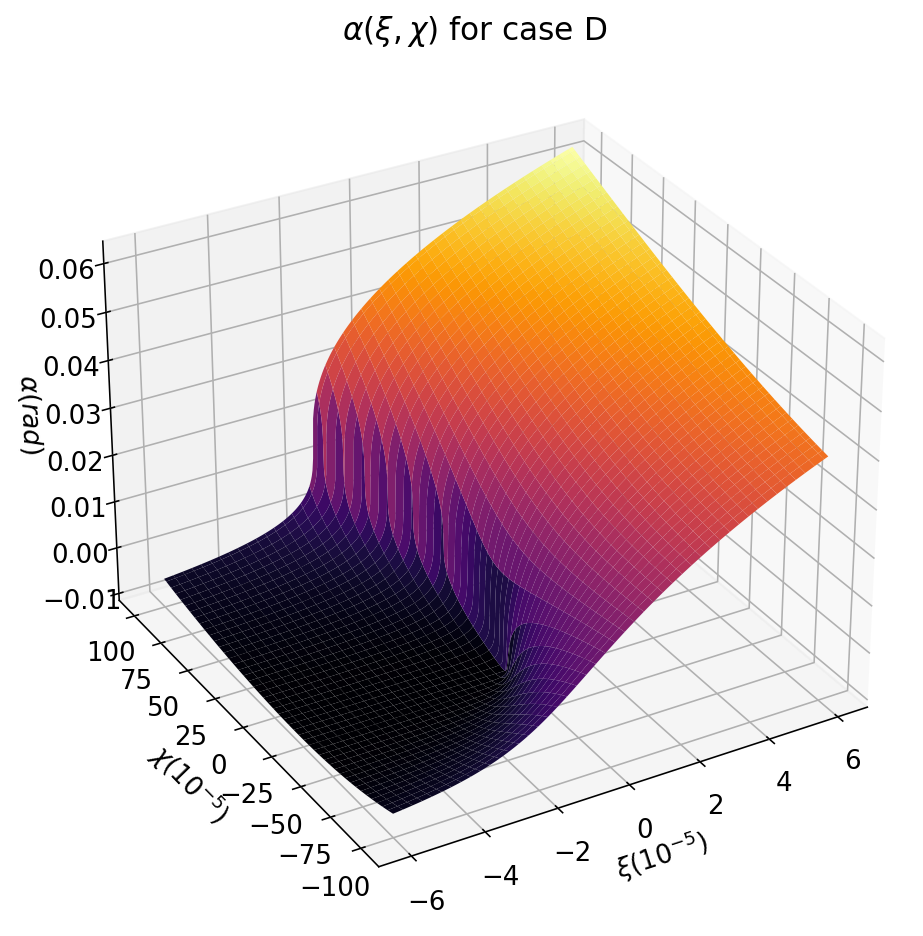

In [10]:
from mpl_toolkits import mplot3d

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
ax.plot_surface(zm*1e5, xm*1e5, GG, cmap='inferno')
#ax.set_xlabel('$z/2/\rho$ (1e-3)')
plt.xlabel(r'$\xi (10^{-5})$')
plt.ylabel(r'$\chi (10^{-5})$')
ax.set_zlabel(r'$\alpha (rad)$')
plt.title(r'$\alpha(\xi,\chi)$ for case D')

ax.azim = 240

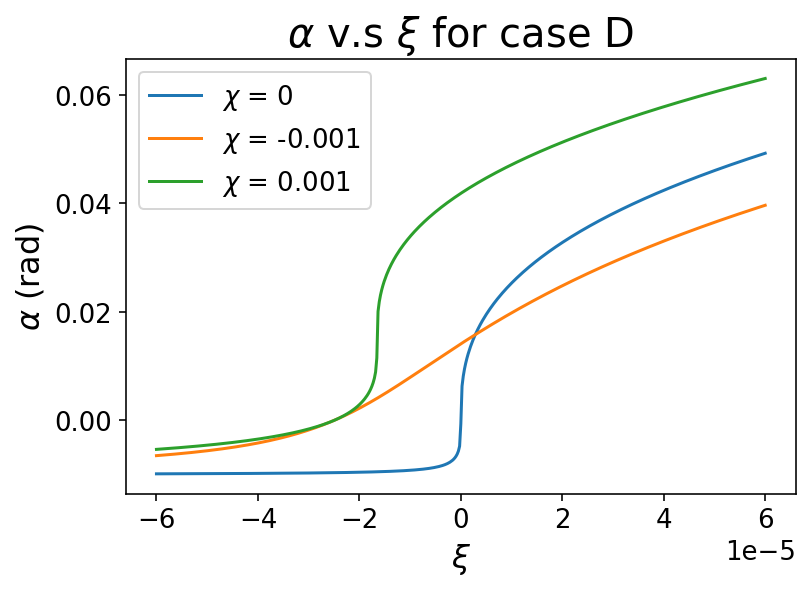

In [11]:
plt.plot(zvec,GG[:,250], label = '$\chi$ = 0')
plt.plot(zvec,GG[:,0],label = '$\chi$ = -0.001')
plt.plot(zvec,GG[:,-1], label = '$\chi$ = 0.001')

plt.xlabel(r'$\xi$', fontsize=16)
plt.ylabel(r'$\alpha$ (rad)', fontsize=16)
plt.title(r'$\alpha$ v.s $\xi$ for case D',  fontsize=20)
plt.legend()

# Below are scratch 

In [128]:
import numpy as np
import scipy
from numba import vectorize, float64, njit
#@vectorize([float64(float64, float64, float64, float64)])

@np.vectorize
def alpha_exact_case_D(z, x, beta, lamb):
    """
    Exact alpha calculation using numerical root finding.

    """
    #beta = np.sqrt(beta2)
    f = lambda a: a + 1/2 * (lamb - beta*np.sqrt(lamb**2 + x**2 + 4*(1+x)*np.sin(a)**2 + 2*lamb*np.sin(2*a)) - z)
    
    res = scipy.optimize.root_scalar(f, bracket=(-1,1))
    
    return res.root


#@vectorize([float64(float64, float64, float64, float64)])
@np.vectorize
def Es_case_D(z, x, beta, lamb):
    """
    Eq.(?) from Ref[2] slide #21 with no constant factor e*beta**2/rho**2.
    Note that 'x' here corresponds to 'chi = x/rho', 
    and 'z' here corresponds to 'xi = z/2/rho' in the paper. 
    """
  
    if z == 0 and x == 0:
        return 0
    
    #beta2 = beta**2
    alp = alpha_exact_case_D(z, x, beta, lamb)
    sin2a = np.sin(2*alp)
    cos2a = np.cos(2*alp) 

    kap = np.sqrt(lamb**2 + x**2 + 4*(1+x)*np.sin(alp)**2 + 2*lamb*np.sin(2*alp)) # kappa for case D
    
    N1 = cos2a - (1+x)
    N2 = lamb*cos2a + (1+x)*sin2a - beta*kap
    D = kap - beta*(lamb*cos2a + (1+x)*sin2a)
    
    return N1*N2/D**3

In [24]:
import numpy as np
zvec = np.linspace(-100,100,101)*1e-6
xvec = np.linspace(-100,100,101)*1e-6
beta = 0.999999
lamb = 0.3
zm,xm = np.meshgrid(zvec, xvec, indexing="ij")

In [130]:
alpha_exact_case_D(zm,xm, beta, lamb)

array([[-0.01473445, -0.01473128, -0.0147281 , ..., -0.0143542 ,
        -0.01434962, -0.01434503],
       [-0.01472838, -0.01472515, -0.01472191, ..., -0.01434146,
        -0.01433681, -0.01433214],
       [-0.01472209, -0.0147188 , -0.01471551, ..., -0.01432826,
        -0.01432353, -0.01431878],
       ...,
       [ 0.0551057 ,  0.05512434,  0.05514299, ...,  0.05698391,
         0.05700359,  0.05702329],
       [ 0.0555403 ,  0.05555887,  0.05557745, ...,  0.05741114,
         0.05743074,  0.05745035],
       [ 0.05596922,  0.05598773,  0.05600625, ...,  0.05783286,
         0.05785237,  0.0578719 ]])

In [129]:
Es_case_D(zm,xm, beta, lamb)

array([[29845.3605577 , 29975.17700394, 30104.64149027, ...,
        41103.10827269, 41204.7888528 , 41306.24200076],
       [30975.70900465, 31109.70942121, 31243.33985383, ...,
        42572.26038245, 42676.79437728, 42781.09131344],
       [32171.67571674, 32310.06042651, 32448.05589801, ...,
        44122.03616898, 44229.54025621, 44336.79710708],
       ...,
       [58122.96886536, 58134.11762953, 58145.17114313, ...,
        58771.11243765, 58773.20916199, 58775.21739722],
       [56807.93903026, 56818.44333587, 56828.85686273, ...,
        57413.91870457, 57415.7993048 , 57417.59561438],
       [55546.46289645, 55556.36695992, 55566.18442927, ...,
        56113.25304534, 56114.93394177, 56116.53447221]])

In [ ]:
f = lambda a: a + 1/2 * (lamb - beta*np.sqrt(lamb**2 + x**2 + 4*(1+x)*np.sin(a)**2 + 2*lamb*np.sin(2*a)) - z)
    
    res = scipy.optimize.root_scalar(f, bracket=(-1,1))